### Data Loading

In [1]:
from feature_data_from_mat import get_high_gamma_data
import numpy as np

In [2]:
pt = 'S14'
hg_trace, hg_map, phon_labels = get_high_gamma_data(f'../data/{pt}/{pt}_HG_sigChannel_goodTrials.mat')

In [3]:
print(hg_trace.shape)
print(np.mean(hg_trace, axis=0).shape)
print(np.mean(np.mean(hg_trace, axis=0), axis=1).shape)

(46, 200, 149)
(200, 149)
(200,)


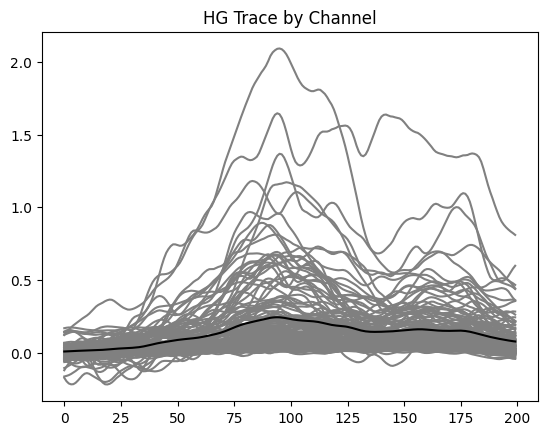

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

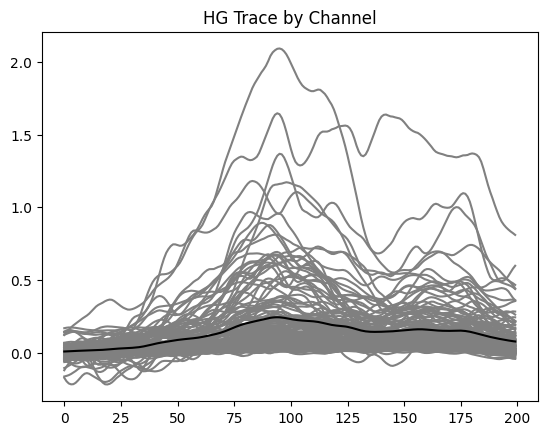

In [5]:
plt.figure()
plt.plot(np.mean(hg_trace, axis=0), 'grey')
plt.plot(np.mean(np.mean(hg_trace, axis=0), axis=1), 'black')
plt.title('HG Trace by Channel')
plt.show()

### Data Preprocessing

In [6]:
from sequence_processing import pad_sequence_teacher_forcing

n_output = 10

In [7]:
X = hg_trace  # use HG traces (n_trials, n_channels, n_timepoints) for 1D CNN
# X1 = S14_hg_map  # use HG channel map stack (n_trials, n_channels_x, n_channels_y, n_timepoints) for 1D CNN
X_prior, y, prior_labels, seq_labels = pad_sequence_teacher_forcing(phon_labels, n_output)  # first 2 outputs one-hot encoded

### MixUp Testing

In [8]:
from sklearn.model_selection import ShuffleSplit
from mixup_generation import generate_mixup

In [9]:
data_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
train_idx, test_idx = next(data_split.split(X))
X_train, X_test = X[train_idx], X[test_idx]
X_prior_train, X_prior_test = X_prior[train_idx], X_prior[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
seq_labels_train, seq_labels_test = seq_labels[train_idx], seq_labels[test_idx]

In [10]:
alpha = 10

In [11]:
mix_X, mix_X_prior, mix_y = generate_mixup(X, X_prior, y, seq_labels)
print(f'X shape: {mix_X.shape}')
print(f'X_prior shape: {mix_X_prior.shape}')
print(f'y shape: {mix_y.shape}')

X shape: (46, 200, 149)
X_prior shape: (46, 3, 10)
y shape: (46, 3, 10)


In [12]:
mix_X_train, mix_X_prior_train, mix_y_train = generate_mixup(
                                                X_train, X_prior_train,
                                                y_train, seq_labels_train,
                                                alpha=1)
print(f'X_train shape: {mix_X_train.shape}')
print(f'X_prior_train shape: {mix_X_prior_train.shape}')
print(f'y_train shape: {mix_y_train.shape}')

mix_X_only = mix_X_train[X_train.shape[0]:,:,:]
print(f'MixUp Train Trials Added: {mix_X_only.shape[0]}')

X_train shape: (36, 200, 149)
X_prior_train shape: (36, 3, 10)
y_train shape: (36, 3, 10)
MixUp Train Trials Added: 0


In [13]:
import matplotlib.pyplot as plt

t = np.linspace(-0.5, 0.5, X_train.shape[1])

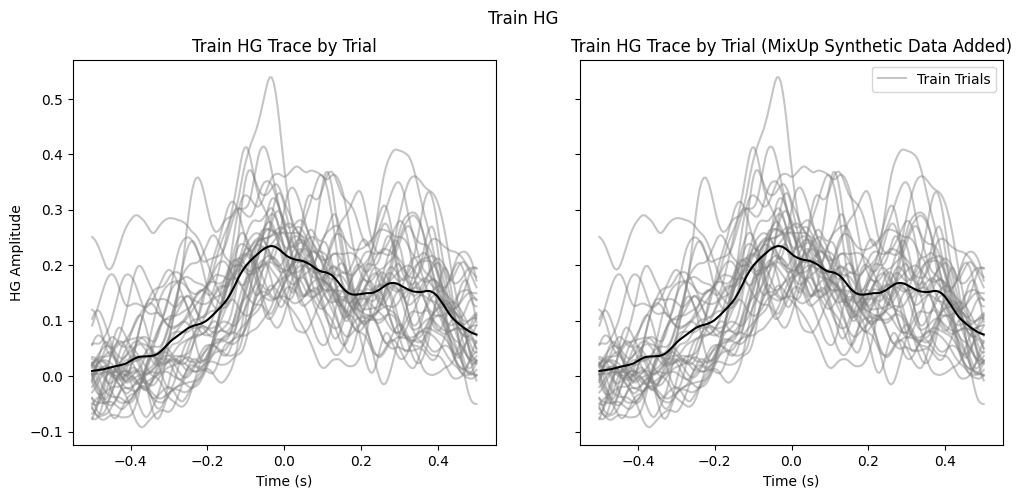

In [14]:


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.plot(t, np.mean(X_train, axis=-1).T, 'grey', alpha=0.45)
ax1.plot(t, np.mean(np.mean(X_train, axis=-1), axis=0), 'black')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('HG Amplitude')
ax1.set_title('Train HG Trace by Trial')

ax2.plot(t, np.mean(X_train, axis=-1).T, 'grey', alpha=0.45, label='Train Trials')
ax2.plot(t, np.mean(mix_X_only, axis=-1).T, 'red', alpha=0.35, label='Mixup Synthetic Trials')
ax2.plot(t, np.mean(np.mean(mix_X_train, axis=-1), axis=0), 'black')
ax2.set_xlabel('Time (s)')
ax2.set_title('Train HG Trace by Trial (MixUp Synthetic Data Added)')

handles, labels = ax2.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2.legend(handles, labels, loc='best')

plt.suptitle('Train HG')
plt.show()

f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\RNN_transfer_learning\RNN_phoneme_decoding_micro\.venv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


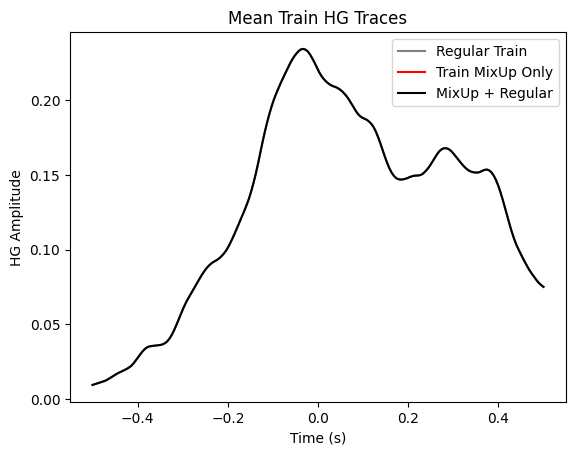

In [15]:
plt.figure()
plt.plot(t, np.mean(np.mean(X_train, axis=-1), axis=0), 'grey', label='Regular Train')
plt.plot(t, np.mean(np.mean(mix_X_only, axis=-1), axis=0), 'red', label='Train MixUp Only')
plt.plot(t, np.mean(np.mean(mix_X_train, axis=-1), axis=0), 'black', label='MixUp + Regular')
plt.xlabel('Time (s)')
plt.ylabel('HG Amplitude')
plt.title('Mean Train HG Traces')
plt.legend()
plt.show()

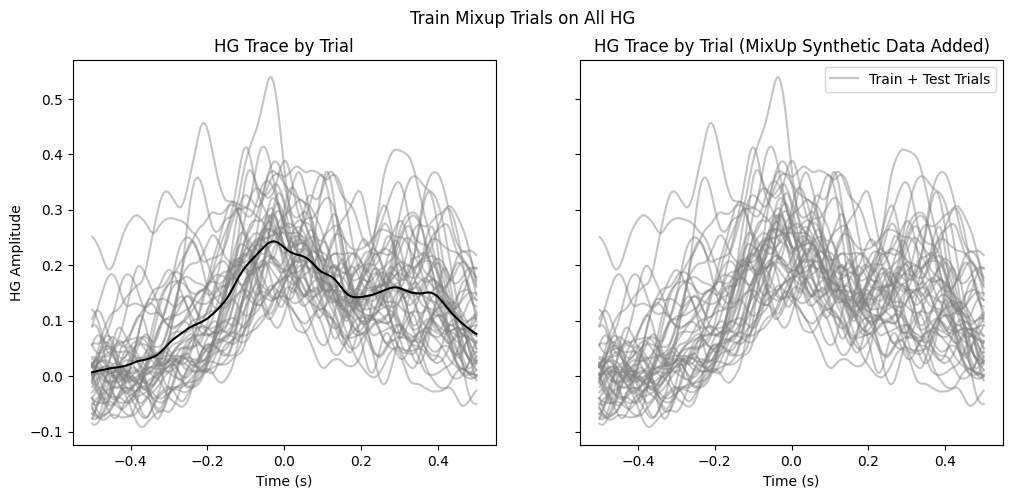

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
ax1.plot(t, np.mean(X, axis=-1).T, 'grey', alpha=0.45)
ax1.plot(t, np.mean(np.mean(X, axis=-1), axis=0), 'black')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('HG Amplitude')
ax1.set_title('HG Trace by Trial')

ax2.plot(t, np.mean(X, axis=-1).T, 'grey', alpha=0.45, label='Train + Test Trials')
ax2.plot(t, np.mean(mix_X_only, axis=-1).T, 'red', alpha=0.25, label='Train Mixup Synthetic Trials')
ax2.set_xlabel('Time (s)')
ax2.set_title('HG Trace by Trial (MixUp Synthetic Data Added)')

handles, labels = ax2.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax2.legend(handles, labels, loc='best')

plt.suptitle('Train Mixup Trials on All HG')
plt.show()